In [3]:
#@title Imports  { form-width: "30%" }

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from graph_nets import graphs
from graph_nets import utils_np
from graph_nets import utils_tf

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import sonnet as snt
import tensorflow as tf
from tensorflow.python.framework import ops

import time
import imp
from matplotlib.pyplot import imshow

from matplotlib import pyplot as plt
import numpy as np
import pickle
import sys
import os
# insert at 1, 0 is the script path (or '' in REPL)

#locally modified modules
sys.path.insert(1, os.getcwd())
import modules
import models
import blocks
import random
from itertools import compress

try:
  import seaborn as sns
except ImportError:
  pass
else:
  sns.reset_orig()

SEED = 1
np.random.seed(SEED)
tf.compat.v1.set_random_seed(SEED)
%matplotlib inline

2022-11-17 14:49:02.766173: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 14:49:02.855405: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-17 14:49:02.876395: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-17 14:49:03.267829: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

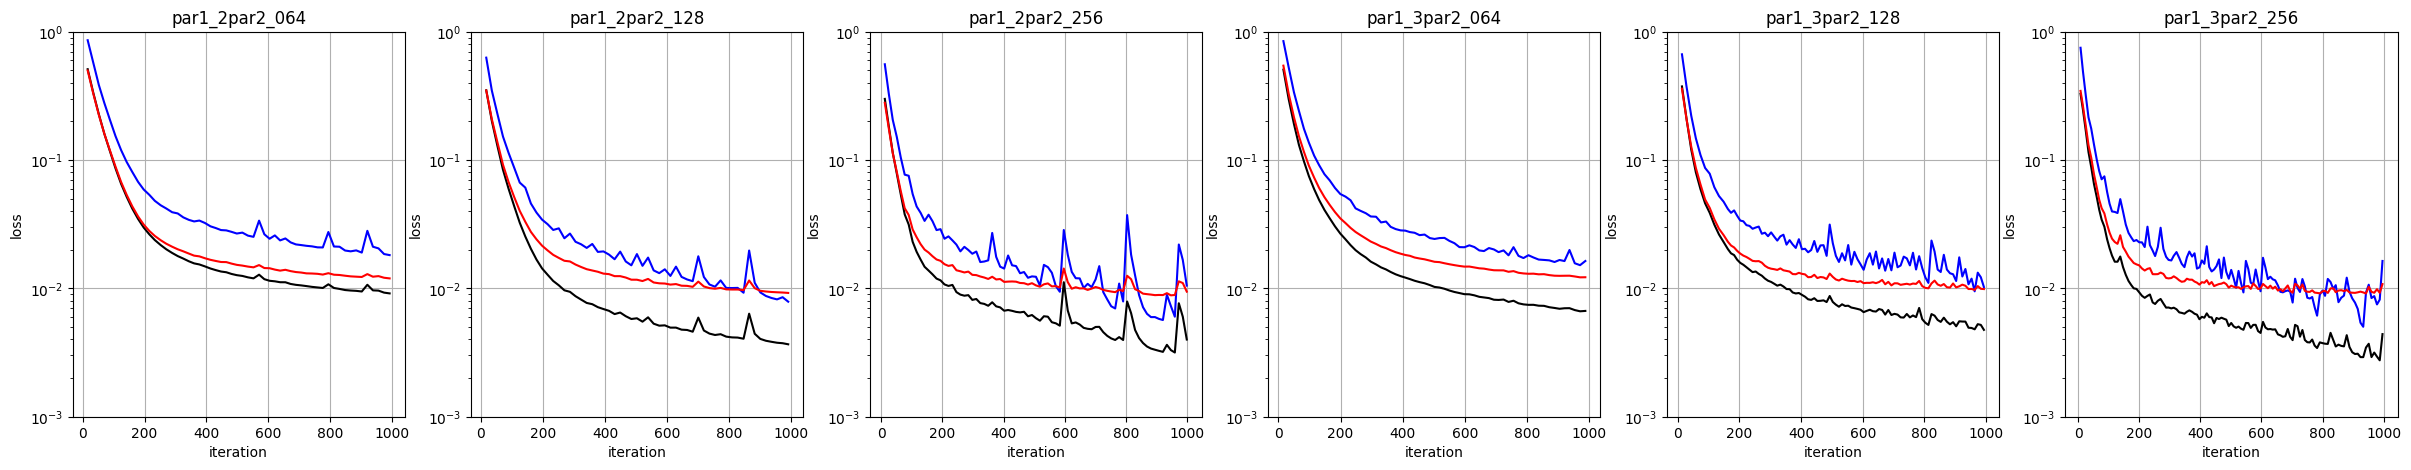

In [4]:
#root_directory='/scratch/dmsm/m.colombo/cases/data/HALE_50_2st2m/loads_layers_units'
root_directory='/home/dmsm/m.colombo/Documents/cases/data/HALE_50_2st2m/loads_layers_units'
dirlist = os.listdir(root_directory)
dirlist= list(compress(dirlist, [os.path.isdir(os.path.join(root_directory,el)) for el in os.listdir(root_directory)]))
dirlist.sort()

fig, ax = plt.subplots(1,len(dirlist),figsize=(30,5))

for directory,idx in zip(dirlist,range(len(dirlist))):

    with open(os.path.join(root_directory,directory,'Errors_result.pickle'), "rb") as file_:
        maeG = pickle.load(file_)
        mseG = pickle.load(file_)
        maeN = pickle.load(file_)
        mseN = pickle.load(file_)
        maeE = pickle.load(file_)
        mseE = pickle.load(file_)
        loss_tr_hist = pickle.load(file_)
        loss_tr_noltl_hist = pickle.load(file_)
        loss_va_hist = pickle.load(file_)
        iteration_hist    = pickle.load(file_)
        ax[idx].semilogy(iteration_hist,loss_tr_hist,'b',label='loss')
        ax[idx].semilogy(iteration_hist,loss_tr_noltl_hist,'k',label='loss no ltl')
        ax[idx].semilogy(iteration_hist,loss_va_hist,'r',label='loss validation')
        ax[idx].set_ylim( (10**-3,10**0) )
        ax[idx].set_title(directory)
        ax[idx].set_xlabel('iteration')
        ax[idx].set_ylabel('loss')
        ax[idx].grid()
        


In [5]:
directory=dirlist[1]
print(directory)

with open(os.path.join(root_directory,directory,'model.pickle'), "rb") as file_:
    model = pickle.load(file_)
with open(os.path.join(root_directory,directory,'Graphs_io.pickle'), "rb") as file_:
    tfgraphs_out_va = pickle.load(file_)
    tfgraphs_tar_va = pickle.load(file_)
    tfgraphs_ro_out = pickle.load(file_)
    tfgraphs_ro_tar = pickle.load(file_) 







par1_2par2_128


2022-11-17 14:49:06.496225: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-11-17 14:49:06.496255: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: m
2022-11-17 14:49:06.496259: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: m
2022-11-17 14:49:06.496382: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.86.0
2022-11-17 14:49:06.496394: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.86.0
2022-11-17 14:49:06.496396: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.86.0
2022-11-17 14:49:06.497337: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX

In [20]:
dt=0.0125

def plot_object(idx_object,n_object,list_tss,list_tse,graph_target,graph_out,filename_fig='Out_vs_tar_'):

    if idx_object==0: #nodes
        jsel=[1,2,3,4]
        isel=[1,3,5,7]
    elif idx_object==4: #globals
        jsel=[0,1,2,5,6,7]       
        isel=[0] 
    else: #edges
        jsel=[0,1,2]
        isel=[0,2,4,6]

    
    
    #n_comp=tfgraphs_out_va[idx_object].shape[1]
    n_comp=len(jsel)

    if idx_object==4:
        fig = plt.figure(1, figsize=(40, 12))
        fig.clf()
        ax = fig.subplots(2, int(n_comp/2))    
        print(ax)    
    else:
        fig = plt.figure(1, figsize=(40, 4*len(isel)))
        fig.clf()
        ax = fig.subplots(len(isel), n_comp)
    step=n_object 

    label_dict=dict();
    label_dict[4]=['x [m]','z [m]','$\\theta $ [deg]','$quat_1$ [-]','$quat_3$ [-]','$dx/dt$ [m/s]','$dz/dt$ [m/s]','$d\\theta/dt$ [deg/s]','$dquat_1/dt$ [-]','$dquat_3/dt$ [-]','$u_w$ [m/s]']
    label_dict[0]=['$y_0$ [m]','z [m]','$\\gamma$ [deg]','$dz/dt$ [m/s]','$d\\gamma/dt$ [deg/s]','mass']
    label_dict[1]=['S [N]','BM [Nm]','TM [Nm]']
    
    label_i_dict=dict()
    label_i_dict[4]=['']
    label_i_dict[0]=['N y='+str(el)+' ' for el in graph_target[0][0:9,0].numpy().astype(int)]
    label_i_dict[1]=['El y='+str(el1/2+el2/2)+' ' for el1,el2 in zip(graph_target[0][0:8,0].numpy().astype(int),graph_target[0][1:9,0].numpy().astype(int))]

    labels=label_dict[idx_object]
    labels_i=label_i_dict[idx_object]
    for i in range(len(isel)):
        for j in range(len(jsel)):
            ii=isel[i]
            jj=jsel[j]

            for ist,iend in zip(list_tss,list_tse):
                
                if step>1:
                    timev=np.arange(ist,iend)*dt-ist*dt
                    ax[i,j].tick_params(axis='both', which='major', labelsize=18)
                    ax[i,j].tick_params(axis='both', which='minor', labelsize=18)

                    if ist==list_tss[0]:
                        ax[i,j].plot(timev,graph_target[idx_object].numpy()[ist*step+ii:iend*step+ii:step,jj],'b--', linewidth=3,label='Target')
                        ax[i,j].plot(timev,graph_out[idx_object].numpy()[ist*step+ii:iend*step+ii:step,jj],'r.-', linewidth=1,label='GN output')
                    else:
                        ax[i,j].plot(timev,graph_target[idx_object].numpy()[ist*step+ii:iend*step+ii:step,jj],'b--', linewidth=3)
                        ax[i,j].plot(timev,graph_out[idx_object].numpy()[ist*step+ii:iend*step+ii:step,jj],'r.-', linewidth=1)
                    ax[i,j].grid(visible=True)
                    ax[i,j].set_xlabel('Time [s]',fontsize=24)                    
                    ax[i,j].set_ylabel(labels_i[ii]+labels[jj],fontsize=24)                    

                else:
                    timev=np.arange(ist,iend)*dt-ist*dt
                    if j<int(n_comp/2):
                        idx_plotj=j
                        idx_ploti=0
                    else:
                        idx_plotj=j-int(n_comp/2)
                        idx_ploti=1

                    ax[idx_ploti,idx_plotj].tick_params(axis='both', which='major', labelsize=10)
                    ax[idx_ploti,idx_plotj].tick_params(axis='both', which='minor', labelsize=8)

                    if ist==list_tss[0]:
                        ax[idx_ploti,idx_plotj].plot(timev,graph_target[idx_object].numpy()[ist:iend,jj],'b--', linewidth=3,label='Target')
                        ax[idx_ploti,idx_plotj].plot(timev,graph_out[idx_object].numpy()[ist:iend,jj],'r.-', linewidth=1,label='GN output')            
                    else:
                        ax[idx_ploti,idx_plotj].plot(timev,graph_target[idx_object].numpy()[ist:iend,jj],'b--', linewidth=3)
                        ax[idx_ploti,idx_plotj].plot(timev,graph_out[idx_object].numpy()[ist:iend,jj],'r.-', linewidth=1)            

                    ax[idx_ploti,idx_plotj].grid(visible=True)
                    ax[idx_ploti,idx_plotj].set_xlabel('Time [s]',fontsize=24)                    
                    ax[idx_ploti,idx_plotj].set_ylabel(labels[jj],fontsize=24)                    
    
    ax[0,0].legend(fontsize=24)

    fig.tight_layout()
    fig.savefig(os.path.join(root_directory,filename_fig+str(idx_object)+'.eps'), format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[   2  132  698 1046 1420 1844 2373 2764 3003 3538 3897 4466]
[ 130  696 1044 1418 1842 2371 2762 3001 3536 3895 4464 4590]
[[<AxesSubplot: > <AxesSubplot: > <AxesSubplot: >]
 [<AxesSubplot: > <AxesSubplot: > <AxesSubplot: >]]


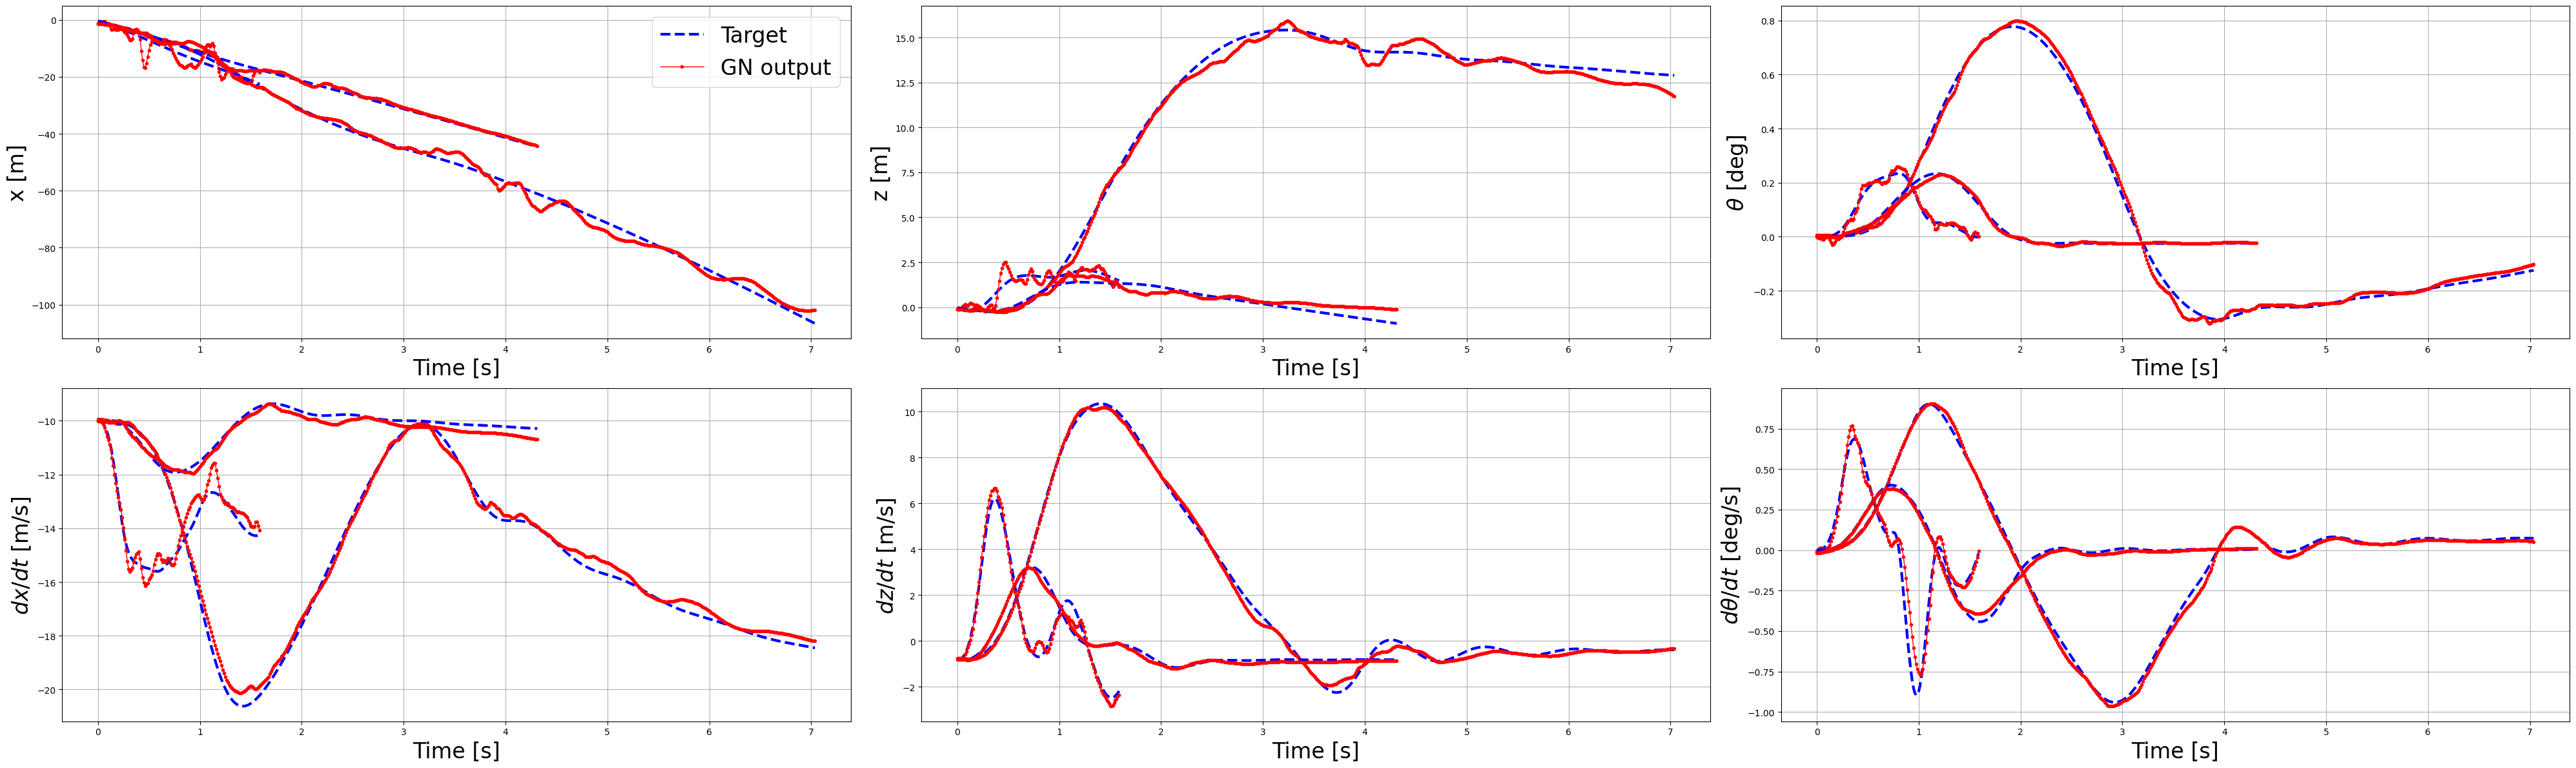

In [21]:
delta_shift=int(directory[-1])  #simple way to get it from name
delta_shift=2

list_td=np.where((tfgraphs_tar_va[4][0:-(delta_shift+1),0]-tfgraphs_tar_va[4][1:-delta_shift,0])<-1)[0]+1
list_tss=np.hstack([0,list_td])
list_tss=list_tss+2
list_tse=np.hstack([list_td,tfgraphs_tar_va[4].shape[0]])
print(list_tss)
print(list_tse)


plot_object(idx_object=4,n_object=1,list_tss=list_tss[0:3],list_tse=list_tse[0:3],graph_target=tfgraphs_tar_va,graph_out=tfgraphs_out_va) #globals




The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


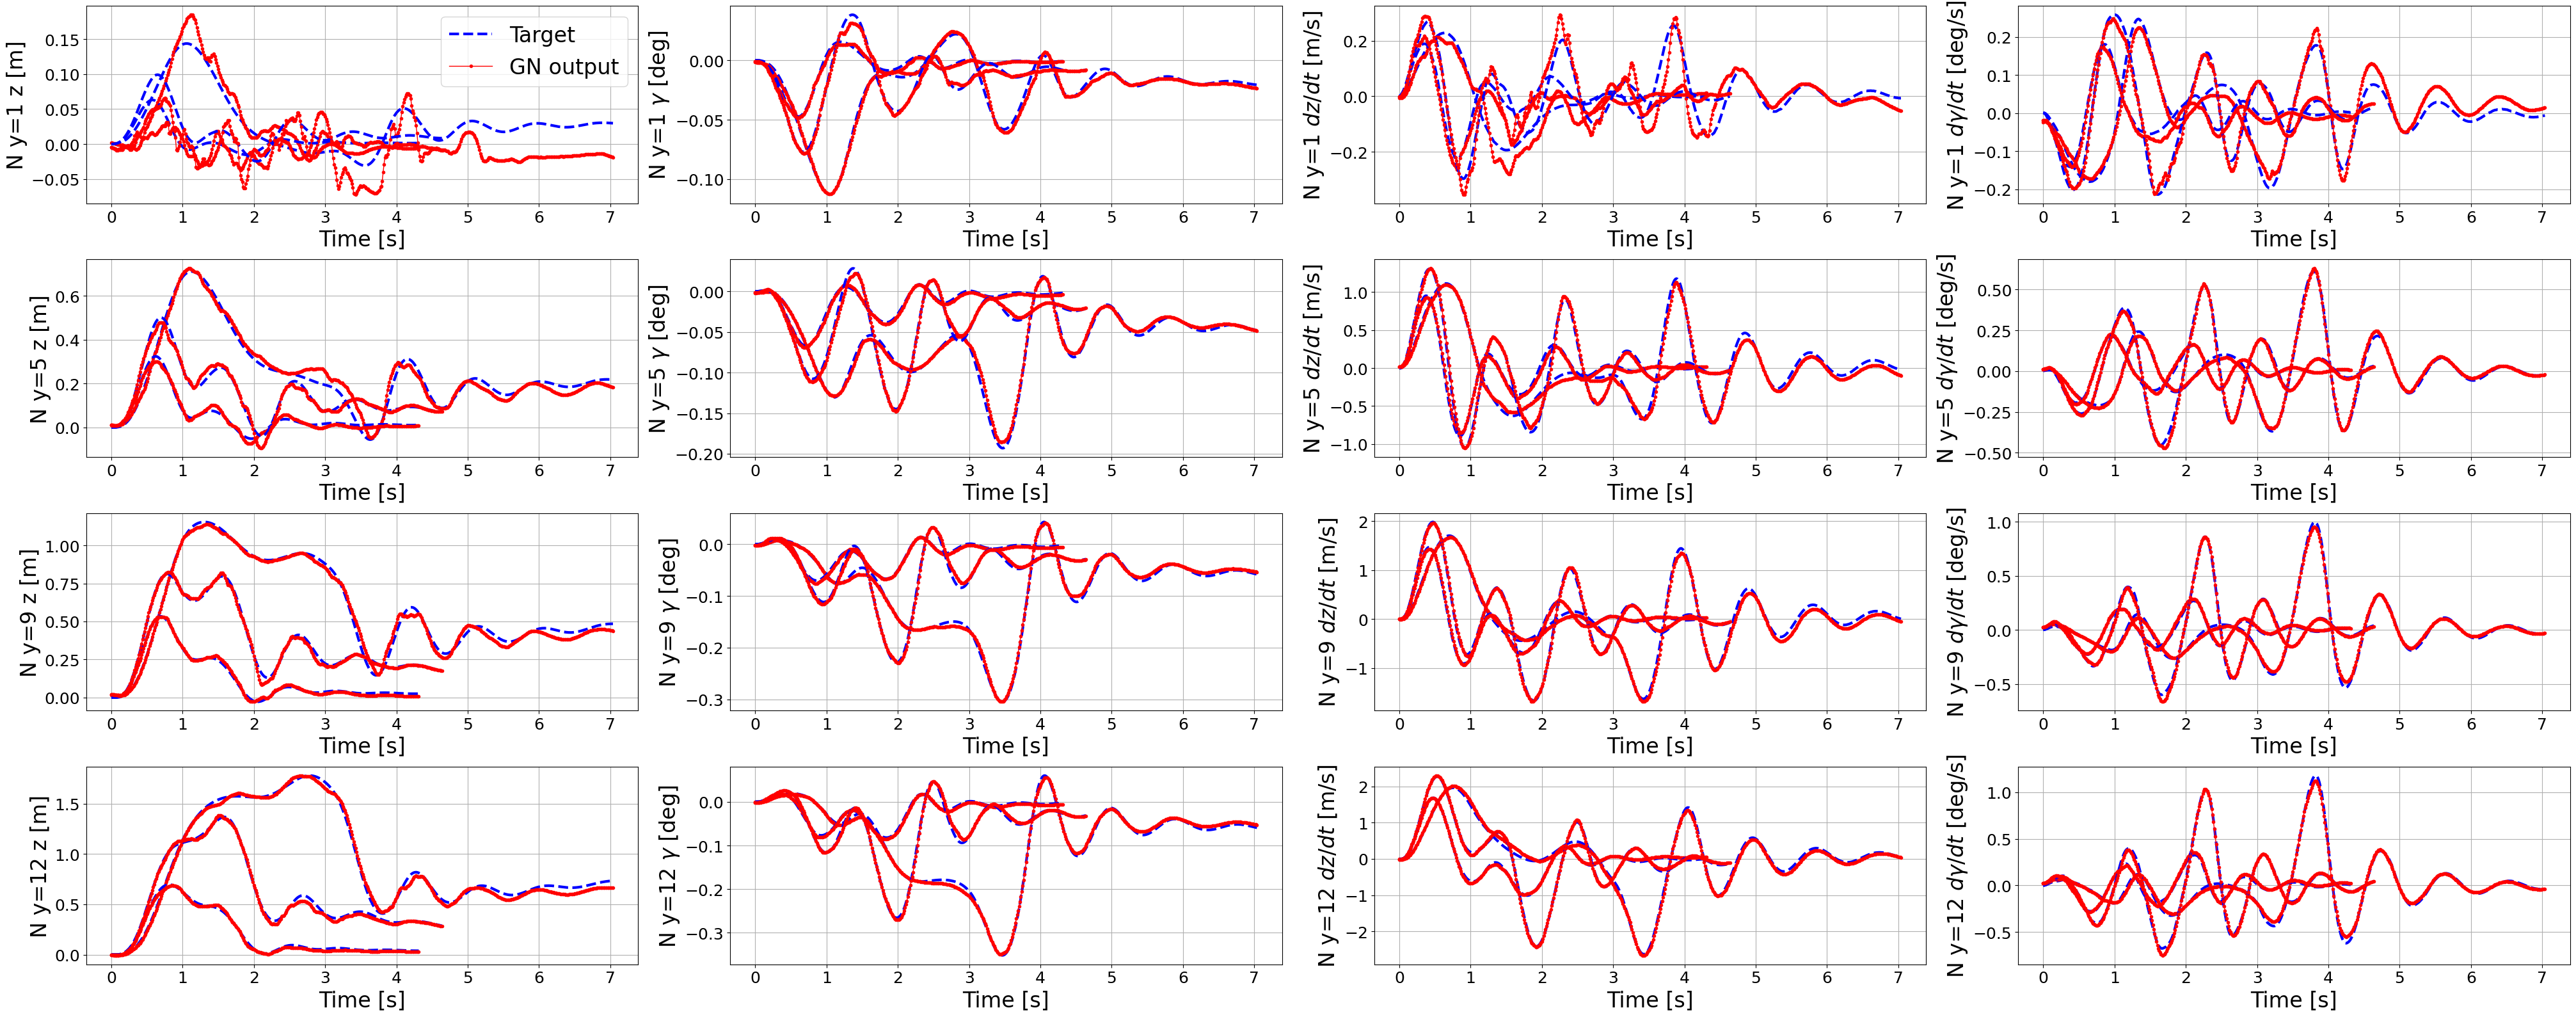

In [22]:
plot_object(idx_object=0,n_object=9,list_tss=list_tss[1:4],list_tse=list_tse[1:4],graph_target=tfgraphs_tar_va,graph_out=tfgraphs_out_va) #nodes va



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


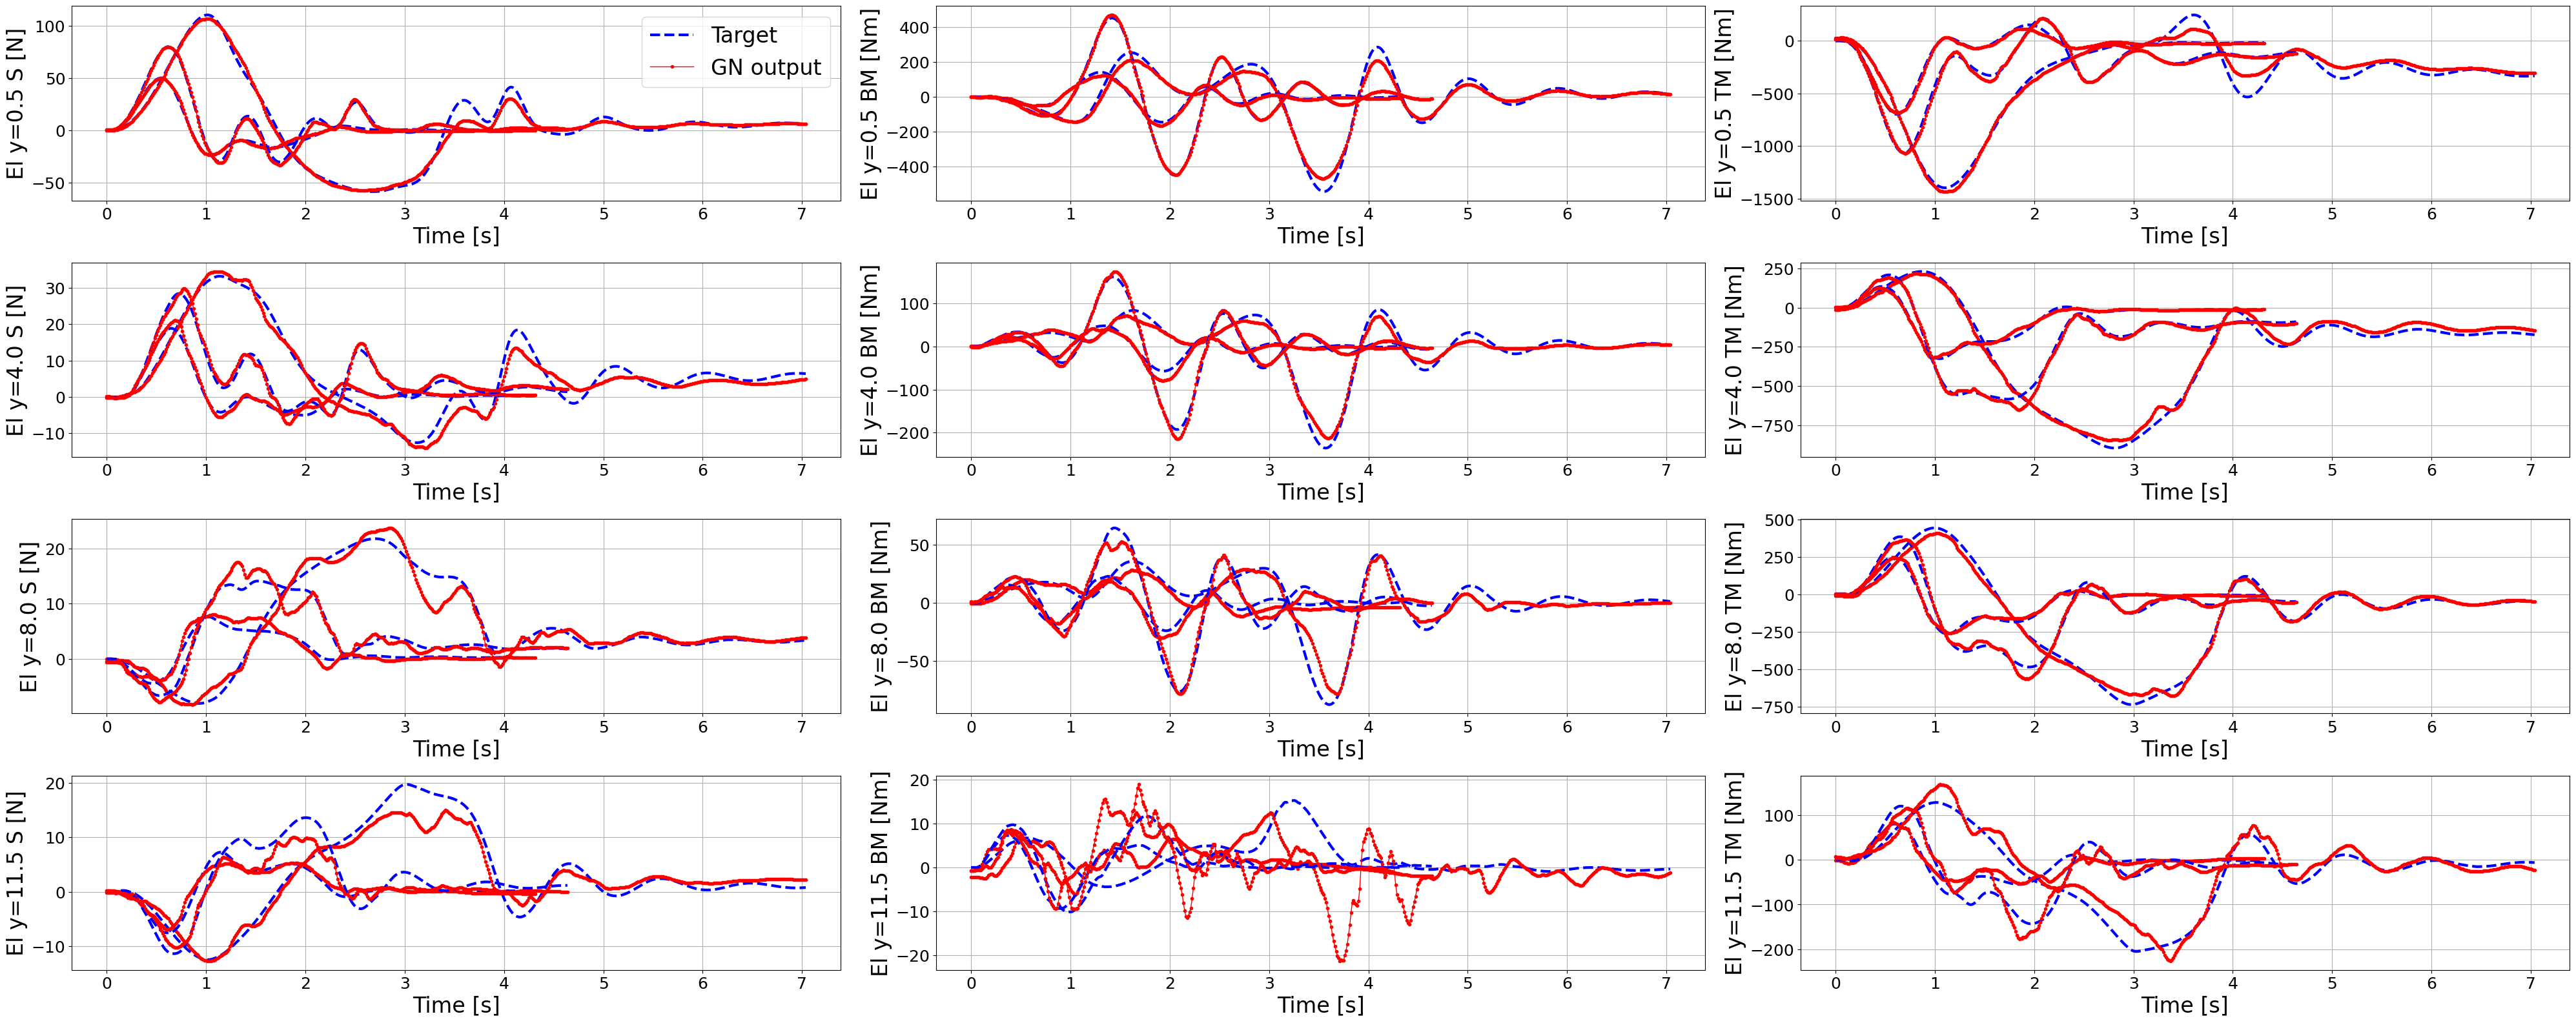

In [23]:
plot_object(idx_object=1,n_object=8,list_tss=list_tss[1:4],list_tse=list_tse[1:4],graph_target=tfgraphs_tar_va,graph_out=tfgraphs_out_va) #loads valid



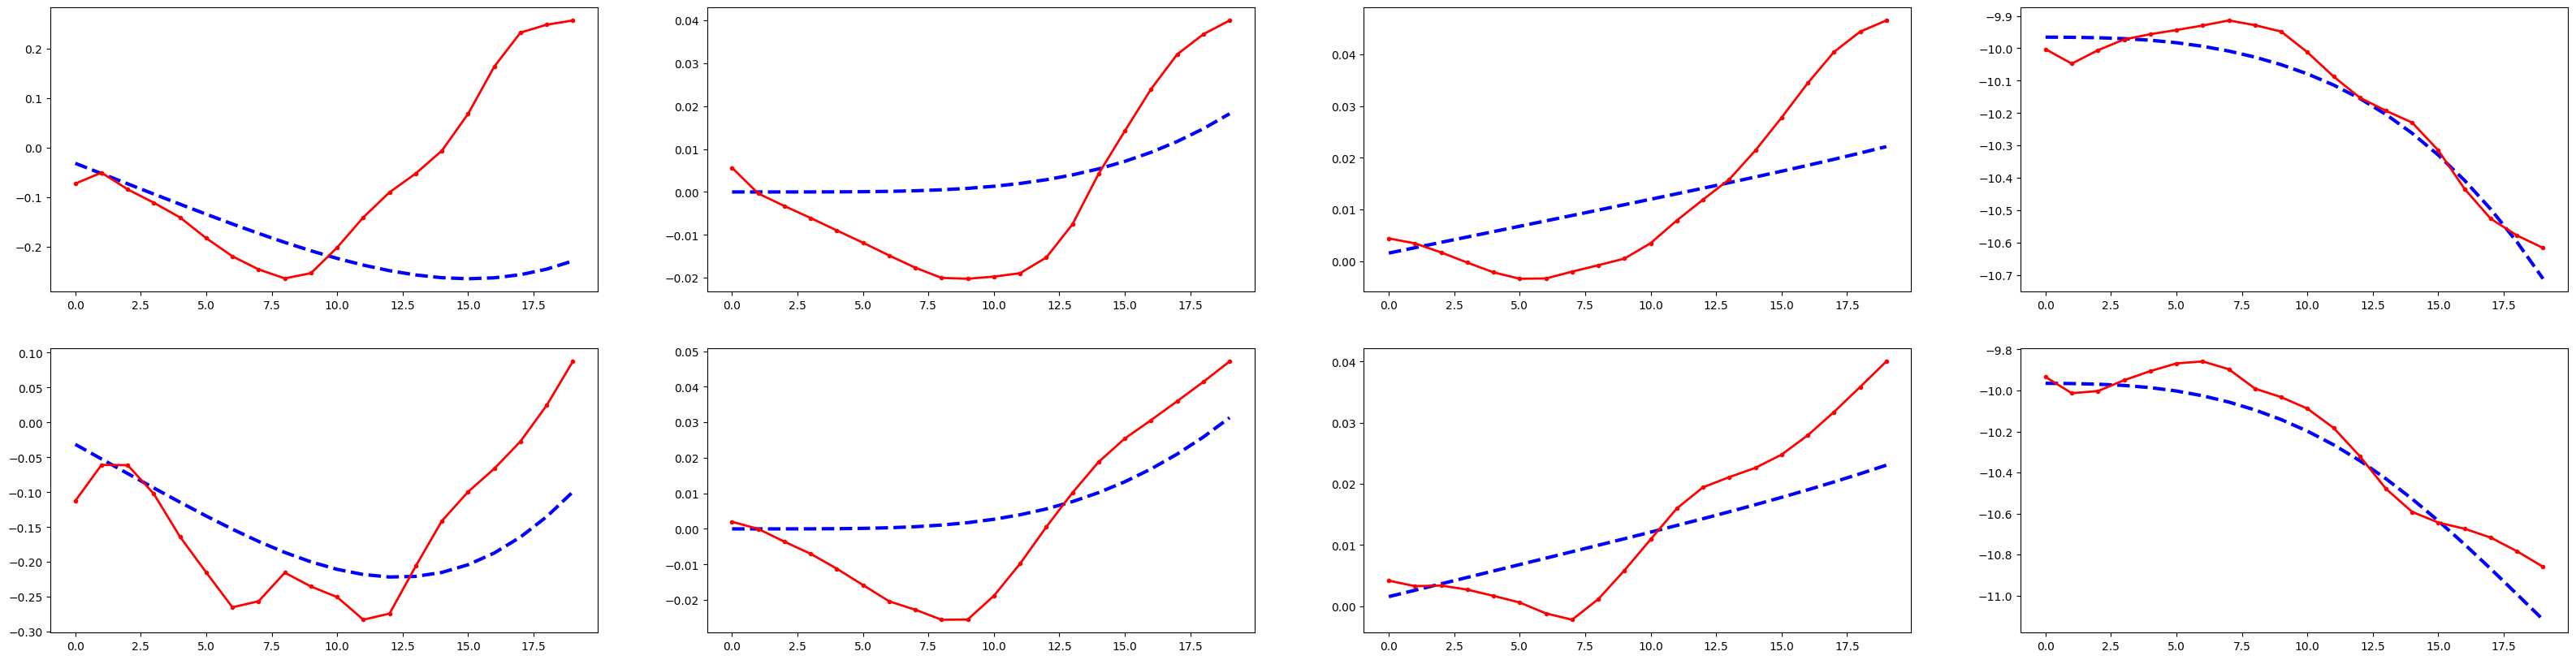

In [29]:

dt=0.0125*delta_shift
isel=[1,2]
jsel=[1,2,4,5]

fig = plt.figure(1, figsize=(40, 5*len(isel)))
fig.clf()
idx_plot=4
idx_els=[0,2,4]
n_comp=tfgraphs_out_va[idx_plot].shape[-1]

ax = fig.subplots(len(isel),len(jsel) )

n_nodes=9
n_edges=8

for i in range(len(isel)):    
    
    tfgraph_ro_out=tfgraphs_ro_out[isel[i]]
    tfgraph_ro_tar=tfgraphs_ro_tar[isel[i]]
    #globs_in=graph_in_va[idxs_start[i]+1]['globals']
    #graph_va_ro = denormalize_graph(graph_va,var_nodes,mean_nodes,var_edgesout,mean_edgesout,var_globals,mean_globals)
    for j in range(len(jsel)):           
        if idx_plot==4: #globals
            ax[i,j].plot(tfgraph_ro_tar[idx_plot][:,jsel[j]],'b--',linewidth=3,label='Target')
            ax[i,j].plot(tfgraph_ro_out[idx_plot][:,jsel[j]],'r.-',linewidth=2,label='GN Output')
        else:  #nodes or edges            
            if idx_plot==0:
                n_els=n_nodes
            elif idx_plot==1:
                n_els=n_edges
            for el in idx_els:
                ax[i,j].plot(tfgraph_ro_tar[idx_plot][el:-1:n_els,jsel[j]],'b')
                ax[i,j].plot(tfgraph_ro_out[idx_plot][el:-1:n_els,jsel[j]],'r.-')
        ax[i,j].grid()
        ax[i,j].grid()



just checking if integrated loads are ok

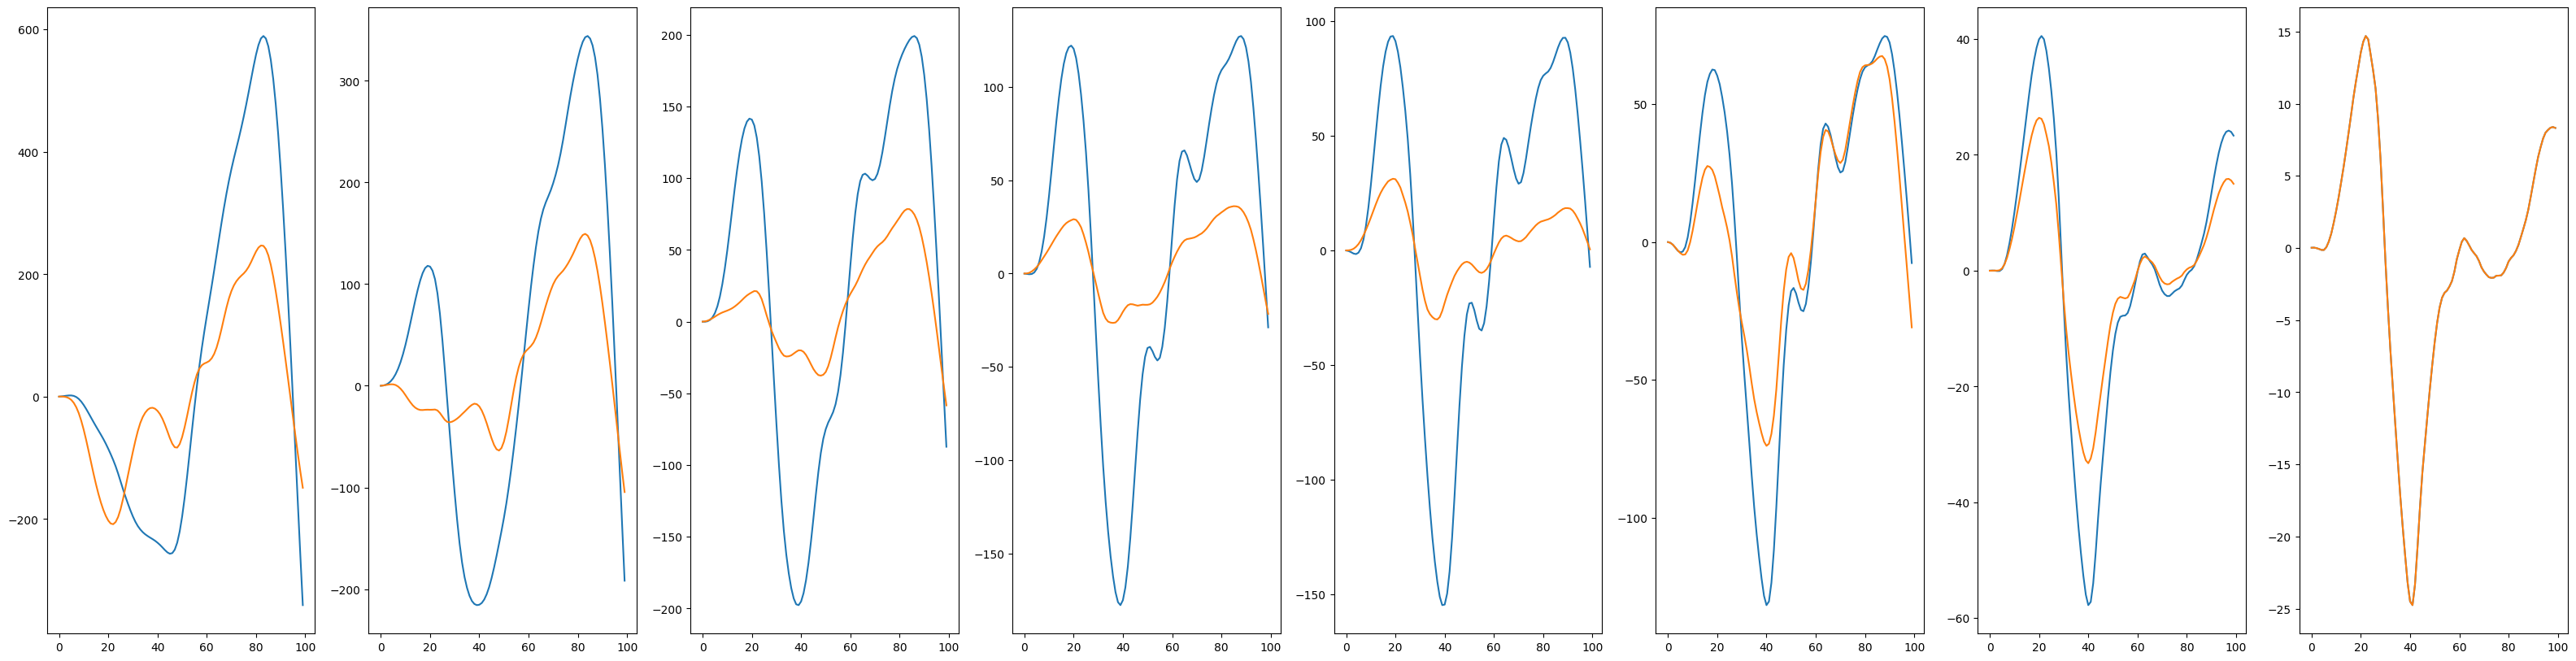

In [51]:
r_directory='/scratch/dmsm/m.colombo/cases/data/HALE_50_2st2m'
nodes_va,    edges_in_va,    edges_tar_va,    globals_va,    senders,    receivers, list_tse_raw    = pickle.load(open(os.path.join(r_directory,'HALE_50_2st2m_loads_va.pickle'), "rb"))
nodes_va,    edges_in_va,    edges_tar_unit_va,    globals_va,    senders,    receivers, list_tse_raw    = pickle.load(open(os.path.join(r_directory,'HALE_50_2st2m_unitloads_va.pickle'), "rb"))

fig,ax = plt.subplots(1,edges_tar_va.shape[0],figsize=(40,10))
for idxel in range(edges_tar_va.shape[0]):
    ax[idxel].plot(edges_tar_va[idxel][3,0:100])
    ax[idxel].plot(edges_tar_unit_va[idxel][3,0:100])


In [46]:
#plt.boxplot(mseE[0:8,:])

def plotError(errE,errN,errG,errtype='Err'):

    y=tfgraphs_tar_va[0][0:9,0]
    yv = [str(int(yy)) for yy in y]

    ax= plt.subplots(1,3,figsize=(10,6),gridspec_kw={'width_ratios': [0.5,1, 1]})

    ax[1][1].set_xticks(np.arange(0, errE.shape[1],1))
    ax[1][1].set_yticks(np.arange(0, errE.shape[0],1))
    ax[1][1].set_xlabel('Load Component')
    ax[1][1].set_ylabel('Edge tip Y axis position')
    ax[1][1].set_yticklabels(yv[1:])
    pos0 = ax[1][1].imshow(errE)
    ax[0].colorbar(pos0, ax=ax[1][1])

    ax[1][2].set_xticks(np.arange(0, errN.shape[1]-2,1))
    ax[1][2].set_yticks(np.arange(0, errN.shape[0],1))
    ax[1][2].set_xlabel('Node Component')
    ax[1][2].set_ylabel('Node Y axis position')
    ax[1][2].set_yticklabels(yv)
    pos1 = ax[1][2].imshow(errN[:,1:-1])
    ax[0].colorbar(pos1, ax=ax[1][2])
    #ax[1][2].set_xticklabels(['z','zd'])

    ax[1][0].set_xticks(np.arange(0, errG.shape[0],1))
    ax[1][0].set_xlabel('Global Component')
    pos2 = ax[1][0].bar(np.arange(0, errG.shape[0]-1,1),mseG[0:-1])
    #ax[1][0].set_xticklabels(['x','z','xd','zd','thd','Uz'])
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(root_directory,errtype+'.eps'), format='eps')

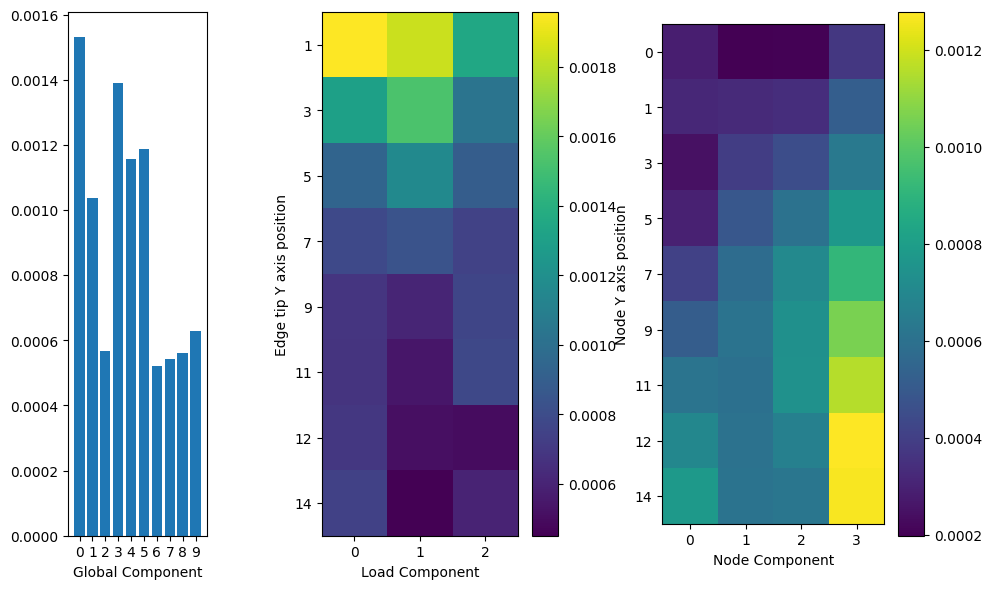

<Figure size 640x480 with 0 Axes>

In [47]:
plotError(mseE,mseN,mseG,errtype='MSE')


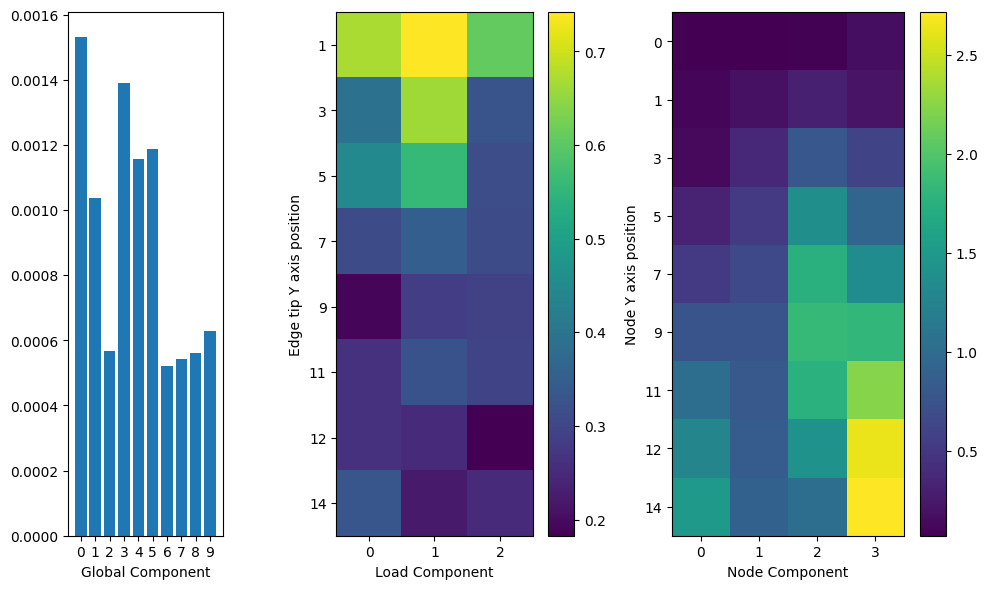

<Figure size 640x480 with 0 Axes>

In [48]:
plotError(maeE,maeN,maeG,errtype='MAE')

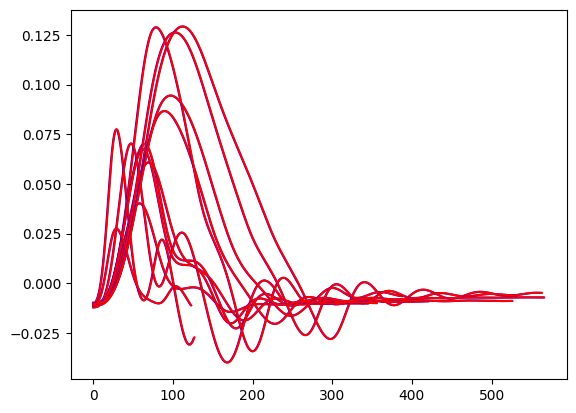

In [ ]:
for ist,iend in zip(list_tss,list_tse):
    plt.plot(np.diff(tfgraphs_tar_va[4].numpy()[ist:iend,1]),'b')
    plt.plot(tfgraphs_tar_va[4].numpy()[ist:iend,1+5]*0.0125,'r')

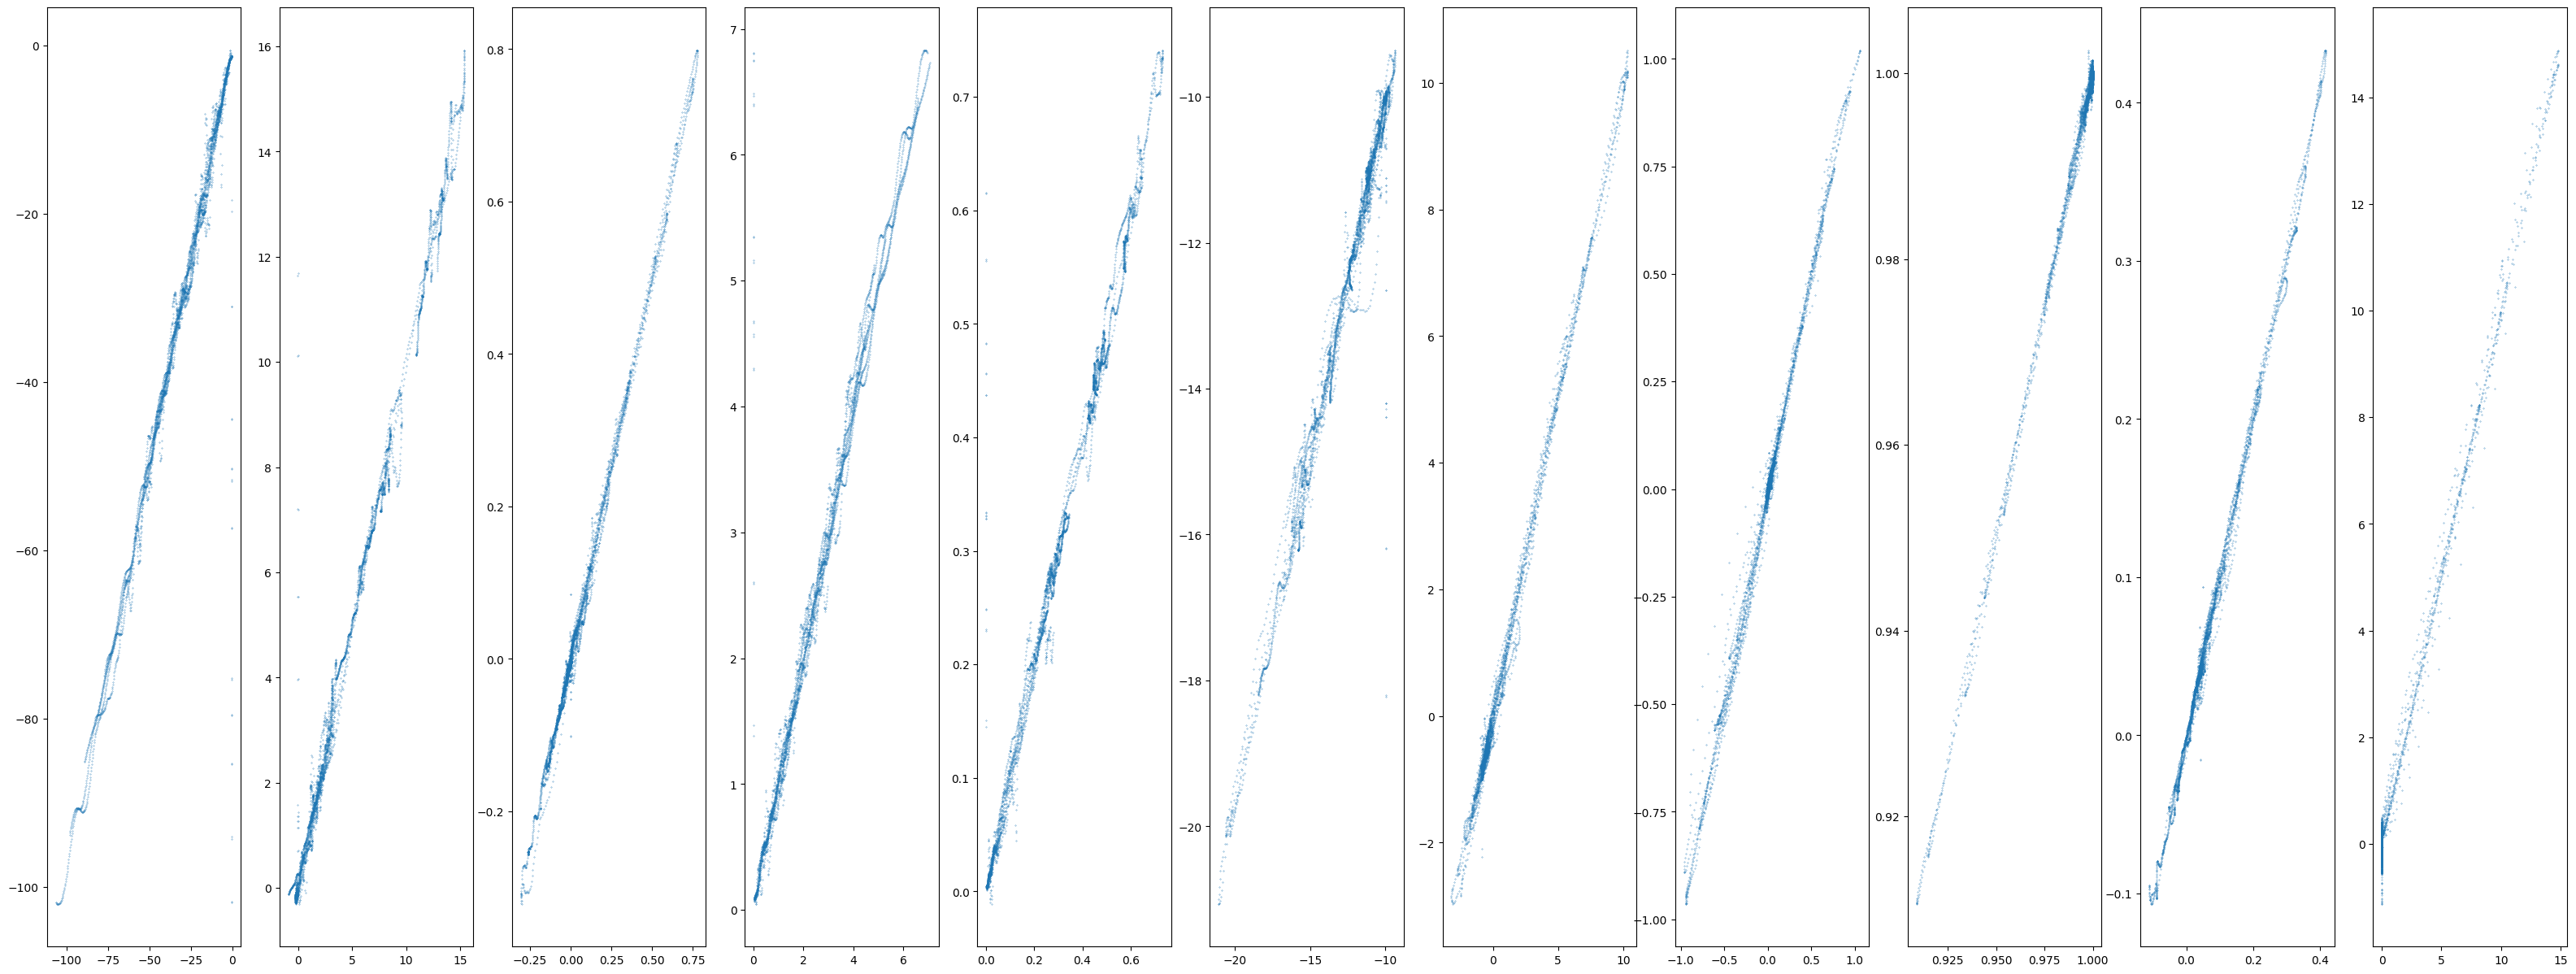

In [55]:
dt=0.0125

def plot_corr(idx_object,n_object,list_tss,list_tse,graph_target,graph_out,filename_fig='Corr_Out_vs_tar_'):

    if idx_object==0: #nodes
        jsel=[1,2,3,4]
        isel=[1,3,5,7]
    elif idx_object==4: #globals
        jsel=[0,1,2,5,6,7]       
        isel=[0] 
    else: #edges
        jsel=[0,1,2]
        isel=[0,2,4,6]

    
    
    #n_comp=tfgraphs_out_va[idx_object].shape[1]
    n_comp=len(jsel)

    if idx_object==4:
        fig = plt.figure(1, figsize=(40, 12))
        fig.clf()
        ax = fig.subplots(2, int(n_comp/2))    
        print(ax)    
    else:
        fig = plt.figure(1, figsize=(40, 4*len(isel)))
        fig.clf()
        ax = fig.subplots(len(isel), n_comp)
    step=n_object 

    label_dict=dict();
    label_dict[4]=['x [m]','z [m]','$\\theta $ [deg]','$quat_1$ [-]','$quat_3$ [-]','$dx/dt$ [m/s]','$dz/dt$ [m/s]','$d\\theta/dt$ [deg/s]','$dquat_1/dt$ [-]','$dquat_3/dt$ [-]','$u_w$ [m/s]']
    label_dict[0]=['$y_0$ [m]','z [m]','$\\gamma$ [deg]','$dz/dt$ [m/s]','$d\\gamma/dt$ [deg/s]','mass']
    label_dict[1]=['S [N]','BM [Nm]','TM [Nm]']
    
    label_i_dict=dict()
    label_i_dict[4]=['']
    label_i_dict[0]=['N y='+str(el)+' ' for el in graph_target[0][0:9,0].numpy().astype(int)]
    label_i_dict[1]=['El y='+str(el1/2+el2/2)+' ' for el1,el2 in zip(graph_target[0][0:8,0].numpy().astype(int),graph_target[0][1:9,0].numpy().astype(int))]

    labels=label_dict[idx_object]
    labels_i=label_i_dict[idx_object]
    for i in range(len(isel)):
        for j in range(len(jsel)):
            ii=isel[i]
            jj=jsel[j]

            for ist,iend in zip(list_tss,list_tse):
                
                if step>1:
                    timev=np.arange(ist,iend)*dt-ist*dt
                    ax[i,j].tick_params(axis='both', which='major', labelsize=18)
                    ax[i,j].tick_params(axis='both', which='minor', labelsize=18)

                    if ist==list_tss[0]:
                        ax[i,j].plot(timev,graph_target[idx_object].numpy()[ist*step+ii:iend*step+ii:step,jj],'b--', linewidth=3,label='Target')
                        ax[i,j].plot(timev,graph_out[idx_object].numpy()[ist*step+ii:iend*step+ii:step,jj],'r.-', linewidth=1,label='GN output')
                    else:
                        ax[i,j].plot(timev,graph_target[idx_object].numpy()[ist*step+ii:iend*step+ii:step,jj],'b--', linewidth=3)
                        ax[i,j].plot(timev,graph_out[idx_object].numpy()[ist*step+ii:iend*step+ii:step,jj],'r.-', linewidth=1)
                    ax[i,j].grid(visible=True)
                    ax[i,j].set_xlabel('Time [s]',fontsize=24)                    
                    ax[i,j].set_ylabel(labels_i[ii]+labels[jj],fontsize=24)                    

                else:
                    timev=np.arange(ist,iend)*dt-ist*dt
                    if j<int(n_comp/2):
                        idx_plotj=j
                        idx_ploti=0
                    else:
                        idx_plotj=j-int(n_comp/2)
                        idx_ploti=1

                    ax[idx_ploti,idx_plotj].tick_params(axis='both', which='major', labelsize=10)
                    ax[idx_ploti,idx_plotj].tick_params(axis='both', which='minor', labelsize=8)

                    if ist==list_tss[0]:
                        ax[idx_ploti,idx_plotj].plot(timev,graph_target[idx_object].numpy()[ist:iend,jj],'b--', linewidth=3,label='Target')
                        ax[idx_ploti,idx_plotj].plot(timev,graph_out[idx_object].numpy()[ist:iend,jj],'r.-', linewidth=1,label='GN output')            
                    else:
                        ax[idx_ploti,idx_plotj].plot(timev,graph_target[idx_object].numpy()[ist:iend,jj],'b--', linewidth=3)
                        ax[idx_ploti,idx_plotj].plot(timev,graph_out[idx_object].numpy()[ist:iend,jj],'r.-', linewidth=1)            

                    ax[idx_ploti,idx_plotj].grid(visible=True)
                    ax[idx_ploti,idx_plotj].set_xlabel('Time [s]',fontsize=24)                    
                    ax[idx_ploti,idx_plotj].set_ylabel(labels[jj],fontsize=24)                    
    
    ax[0,0].legend(fontsize=24)

    fig.tight_layout()
    fig.savefig(os.path.join(root_directory,filename_fig+str(idx_object)+'.eps'), format='eps')
